In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import pymc3 as pm

%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['font.size'] = 14

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
weather = pd.read_csv("data/eindhoven.txt")


/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,4,11,12,13,14,15,16,17,18,19,20,25,26,27,28,29,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# clean whitespaces in the columns
weather.columns = [c.replace(" ", "") for c in weather.columns]

# Parse date information
weather['date'] = (weather['YYYYMMDD']
  .astype(str)
  .map(lambda date: f"{date[:4]}-{date[4:6].zfill(2)}-{date[6:8].zfill(2)}"))
weather['date'] = pd.to_datetime(weather['date'])

# Get correct types for a selection of columns
weather['max_temp'] = pd.to_numeric(weather['TX'].str.strip())
weather['min_temp'] = pd.to_numeric(weather['TN'].str.strip())
weather['rain'] = pd.to_numeric(weather['RH'].str.strip())
weather['sunshine_duration'] = pd.to_numeric(weather['SQ'].str.strip())
weather['solar_energy'] = pd.to_numeric(weather['Q'].str.strip())

# Keep a selection of columns
keep_columns = ['date', 'min_temp', 'max_temp', 'rain', 'sunshine_duration', 'solar_energy']
weather = weather[keep_columns].fillna(0)

# Adding features
weather['day_of_week'] = weather.date.dt.weekday_name
weather['week_of_year'] = weather.date.dt.weekofyear
weather['month'] = weather.date.dt.month
weather['year'] = weather.date.dt.year

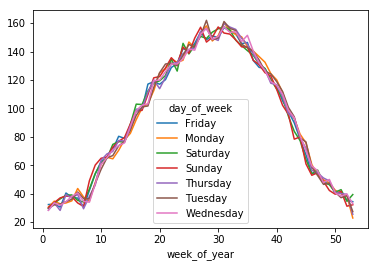

In [4]:
(weather
 .groupby(['week_of_year', 'day_of_week'])
 .mean()['max_temp']
 .unstack()
 .plot());

In [5]:
# weather by week
weather.index = weather.date
weeks = weather.to_period(freq='W')
week_weather = weeks.groupby(weeks.index).mean()
week_weather.index = week_weather.index.to_timestamp()
mask_til94 = week_weather.index < pd.datetime(1994, 1, 1)
week_weather = week_weather[mask_til94]

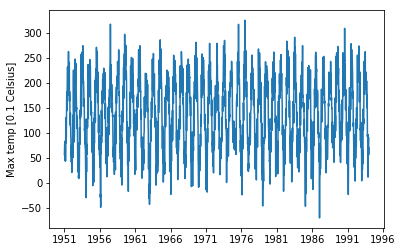

In [6]:
plt.plot(week_weather.index, week_weather.max_temp);
plt.ylabel('Max temp [0.1 Celsius]');

In [7]:
# Creating radial basis functions for week of the year
f_rbf = lambda x, alpha, mu: np.exp((-1/(2*alpha)) * (x - mu)**2)  # radial basis function
f_rbf_vec = lambda x: np.array([f(x) for f in [eval('lambda x: f_rbf(x, 1, {0})'.format(i))
                                      for i in np.arange(53)]])
weights_guess = np.ones(53)
woy = week_weather.week_of_year
y = week_weather.max_temp

In [8]:
# woy: week of year
f_week_rbf = lambda weights, woy: np.dot(f_rbf_vec(woy).T, weights)

In [9]:
def error(weights, woy):
    return f_week_rbf(weights, woy) - y
# print(error(weights_guess, woy))

In [10]:
week_sol = optimize.least_squares(error, weights_guess, args=(woy,))

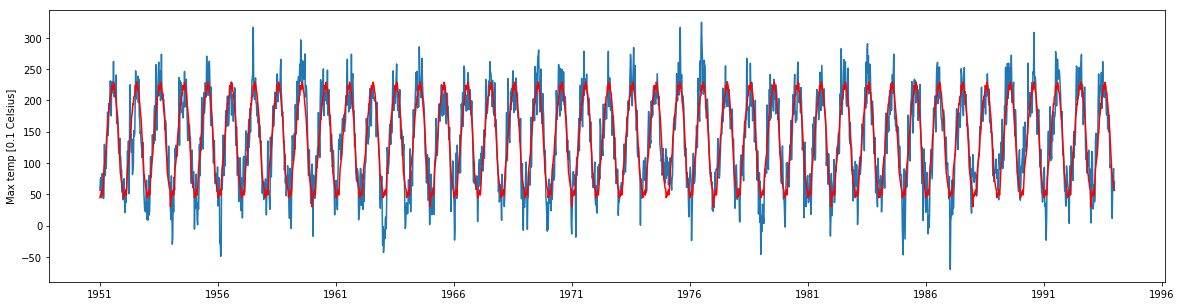

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(week_weather.index, week_weather.max_temp);
ax.set_ylabel('Max temp [0.1 Celsius]')
ax.plot(week_weather.index, f_week_rbf(week_sol.x, woy), 'r');

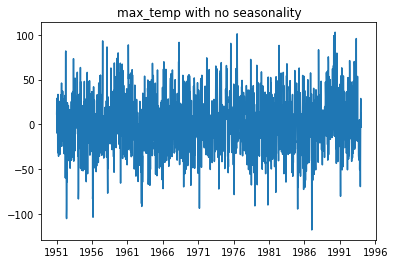

In [12]:
# Subtracting the seasonality of week of the year from the max_temparature
week_weather['season_woy'] = f_week_rbf(week_sol.x, woy)
week_weather = week_weather.assign(no_season = lambda r: r.max_temp - r.season_woy)
plt.plot(week_weather.index, week_weather.no_season)
plt.title('max_temp with no seasonality');

In [13]:
three_years = week_weather[
    (week_weather.index > pd.datetime(1990, 1, 1)) & 
    (week_weather.index < pd.datetime(1993, 1, 1))]

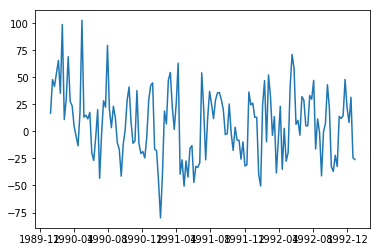

In [14]:
plt.plot(three_years.index, three_years.no_season)

# PMC3 stuff

In [15]:
basic_model = pm.Model()
with basic_model:
    alpha = pm.Normal('alpha')
    obs = pm.Normal('obs', mu = alpha * woy.values, observed=week_weather.no_season.values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:06<00:00, 865.96it/s]


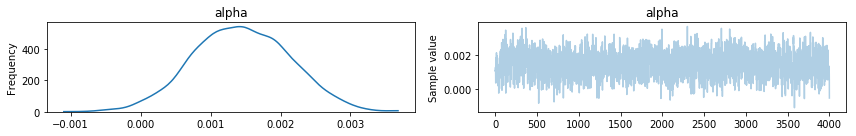

In [16]:
with basic_model:
    trace = pm.sample(5000, model=basic_model)
    _ = pm.traceplot(trace[1000:])

# another version

In [23]:
# Observations
observations = week_weather.no_season.values
month = week_weather.month.values
week_of_the_year = week_weather.week_of_year.values
print(observations.shape)
print(month.shape)
print(week_of_the_year.shape)

(2244,)
(2244,)
(2244,)


In [24]:
basic_model_2 = pm.Model()
with basic_model_2:
    alpha = pm.Normal('alpha')
    beta = pm.Normal('beta')
    mu = alpha*month + beta+week_of_the_year
    obs = pm.Normal('obs', mu=mu, observed=observations)

In [25]:
with basic_model_2:
    adv_trace = pm.sample(5000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 96%|█████████▌| 5285/5500 [00:23<00:00, 228.15it/s]/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 3 does not match the target. It is 0.931788116922, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 97%|█████████▋| 5312/5500 [00:23<00:00, 227.92it/s]/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.896231561744, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|█████████▉| 5488/5500 [00:23<00:00, 230.27it/s]/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in ch

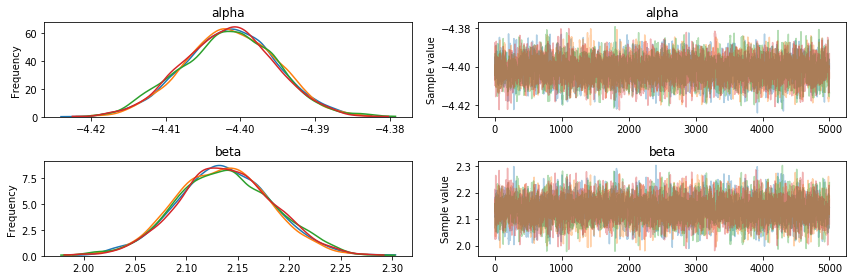

In [26]:
pm.traceplot(adv_trace);

In [27]:
alpha_mu = np.mean(adv_trace.get_values('alpha'))

# Autoregression

In [75]:
minus_1 = week_weather.no_season.shift(-1).ffill().values

In [61]:
basic_model_3 = pm.Model()
with basic_model_3:
    sd = pm.HalfNormal('sd')
    alpha = pm.Normal('alpha', mu=0, sd=sd)
    mu = alpha*minus_1
    obs = pm.Normal('obs', mu=mu, observed=observations)

In [62]:
with basic_model_3:
    adv_trace = pm.sample(5000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 71%|███████   | 3895/5500 [00:19<00:07, 204.30it/s]/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 41 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 82%|████████▏ | 4513/5500 [00:20<00:04, 221.67it/s]/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 3 contains 17 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 96%|█████████▌| 5277/5500 [00:21<00:00, 244.30it/s]/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 2 contains 38 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_

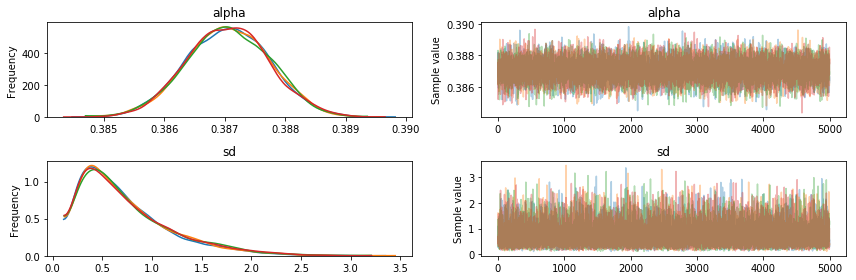

In [63]:
pm.traceplot(adv_trace);

In [64]:
alpha_mu = np.mean(adv_trace.get_values('alpha'))

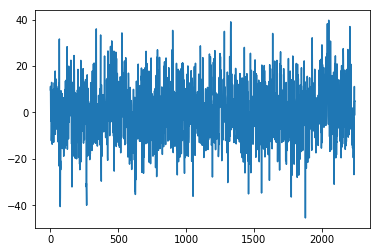

In [65]:
plt.plot(alpha_mu*minus_1)

In [69]:
week_weather['autocorr'] = alpha_mu*minus_1
week_weather = week_weather.assign(no_auto = lambda r: r.no_season - r.autocorr)

In [70]:
# Autocorrelation reduces the variance
week_weather.var()

min_temp               2804.730421
max_temp               4919.044264
rain                    160.119532
sunshine_duration       608.090890
solar_energy         249591.091222
week_of_year            227.042787
month                    11.477277
year                    154.111668
season_woy             4010.151977
no_season               915.822493
autocorr                137.202610
no_auto                 778.618154
dtype: float64

Text(0.5,1,'removing autocorrelation')

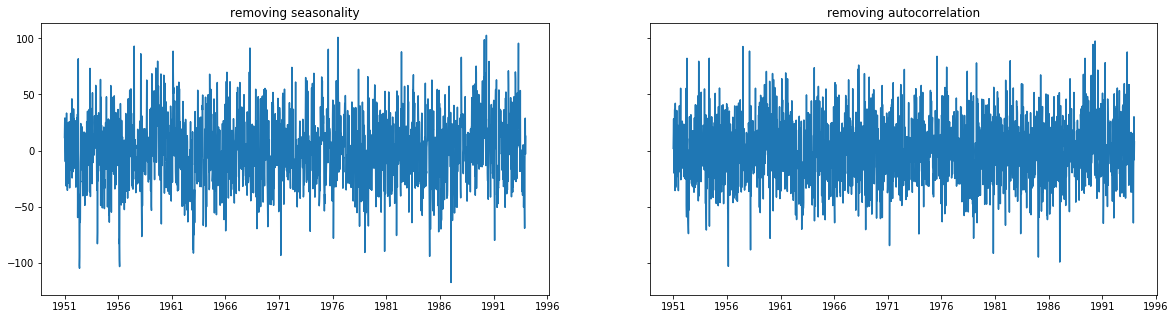

In [74]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(20,5))
ax[0].plot(week_weather.index, week_weather.no_season)
ax[0].set_title('removing seasonality')
ax[1].plot(week_weather.index, week_weather.no_auto)
ax[1].set_title('removing autocorrelation')

# Adding features

sunshine duration measurements started on 1978-03-13 (index 1419)
solar energy measurements started on 1984-07-02 (index 1748).
rain measumrements strated on 1985-03-18 (index 1785)

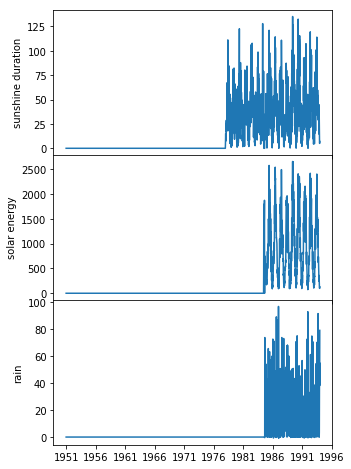

In [84]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(5, 8))
ax[0].plot(week_weather.index, week_weather.sunshine_duration)
ax[0].set_ylabel('sunshine duration')
ax[1].plot(week_weather.index, week_weather.solar_energy)
ax[1].set_ylabel('solar energy')
ax[2].plot(week_weather.index, week_weather.rain)
ax[2].set_ylabel('rain')
fig.subplots_adjust(hspace=0)

In [98]:
(week_weather.sunshine_duration == 0).sum()

1419

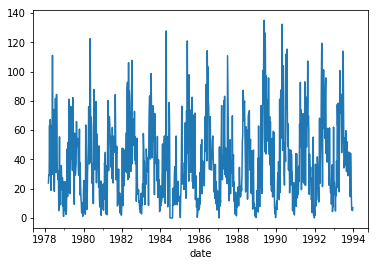

In [90]:
week_weather[-825:].sunshine_duration.plot()

In [99]:
week_weather.index[1419]

Timestamp('1978-03-13 00:00:00', freq='W-MON')